# Import libraries

In [1]:
from util import *
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import trange, tqdm
import stepic
from PIL import Image, ImageOps

# Mask

[[0 1 1 0 0 0 0 0]
 [1 0 1 1 1 1 1 1]
 [1 1 0 1 0 1 0 1]
 [1 0 1 1 0 1 1 1]
 [1 1 0 0 0 1 0 1]
 [0 0 1 0 1 0 1 1]
 [0 0 1 0 0 1 1 1]
 [0 0 1 0 0 1 0 0]]


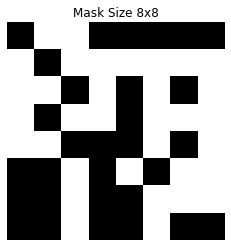

In [2]:
mask_size_w, mask_size_h = 8, 8
# mask = np.random.randint(low=0, high=2, size=(mask_size_w, mask_size_h))
mask = np.array([[0, 1, 1, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 0, 1, 0, 1, 0, 1],
 [1, 0, 1, 1, 0, 1, 1, 1],
 [1, 1, 0, 0, 0, 1, 0, 1],
 [0, 0, 1, 0, 1, 0, 1, 1],
 [0, 0, 1, 0, 0, 1, 1, 1],
 [0, 0, 1, 0, 0, 1, 0, 0]])
print(mask)

plt.title('Mask Size %dx%d'%mask.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

# Loading images

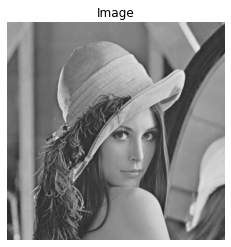

shape (512, 512, 3)


In [3]:
img_path = '../images/lena_gray.bmp'
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB).astype('int16')

img_size_w, img_size_h = img.shape[0], img.shape[1]

img_size_w = img_size_w if img_size_w % mask.shape[0] == 0 else img_size_w + (mask.shape[0] - img_size_w % mask.shape[0])
img_size_h = img_size_h if img_size_h % mask.shape[1] == 0 else img_size_h + (mask.shape[1] - img_size_h % mask.shape[1])

img = cv2.resize(img, (img_size_h, img_size_w), interpolation = cv2.INTER_AREA)

plt.title('Image')
plt.imshow(img)
plt.axis('off')
plt.show()

print('shape', img.shape)

# RS diagram

In [4]:
print('Rm->%f\tSm->%f'%calculate_count_groups(img[:,:,0], mask))
print('R-m->%f\tS-m->%f'%calculate_count_groups(img[:,:,0], -mask))

Rm->0.700195	Sm->0.221191
R-m->0.702881	S-m->0.214111


In [5]:
r_m, s_m, r_neg_m, s_neg_m = [], [], [], []
range_iter =trange(20, leave=True)

channels = [img[:, :, k] for k in range(img.shape[2])]

for i in range_iter:
    temp_rm, temp_sm, temp_r_neg_m, temp_s_neg_m = rs_helper(channels, mask, flip=True, percent=i*.05)
        
    r_m.append(temp_rm); r_neg_m.append(temp_r_neg_m)
    s_m.append(temp_sm); s_neg_m.append(temp_s_neg_m)
    
    range_iter.set_postfix_str('Rm->%f, R-m->%f, Sm->%f, S-m->%f'%(r_m[-1], r_neg_m[-1], s_m[-1], s_neg_m[-1]))
    range_iter.refresh()

100%|██████████| 20/20 [00:54<00:00,  2.74s/it, Rm->0.405843, R-m->0.859701, Sm->0.497070, S-m->0.095052]


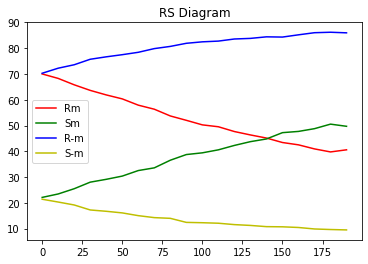

In [6]:
plt.title('RS Diagram')

plt.plot(range(0, 10*len(r_m), 10), 100*np.array(r_m), 'r', label = "Rm")
plt.plot(range(0, 10*len(s_m), 10), 100*np.array(s_m), 'g', label = 'Sm')
plt.plot(range(0, 10*len(r_neg_m), 10), 100*np.array(r_neg_m), 'b', label = 'R-m')
plt.plot(range(0, 10*len(s_neg_m), 10), 100*np.array(s_neg_m), 'y', label = 'S-m')
plt.legend()

# plt.savefig('./output-rs-diagram%s.jpg'%img_path.strip().split('/')[-1].split('.png')[0].strip(), facecolor='w', edgecolor='none')
plt.show()

# Extrapolation on stego-image

In [4]:
max_mesg_hiding_capacity = img_size_h * img_size_w / 8     # One pixel per bit of a byte of data

initial_bias = 0

act, pred = [], []
for i in tqdm(range(20)):
    
    # Random message generation
    message_length_percent = 0.05 * i

    channels = [scattered_lsb_flipping(img[:, :, k], message_length_percent / 2) for k in range(img.shape[2])]
    
    rm_p, sm_p, r_neg_p, s_neg_p = rs_helper(channels, mask)


    p_flipped = [rm_p, sm_p, r_neg_p, s_neg_p]

    channels = [np.bitwise_xor(channel, 1) for channel in channels]

    rm_all_flip, sm_all_flip, r_neg_all_flip, s_neg_all_flip = rs_helper(channels, mask)

    all_flipped = [rm_all_flip, sm_all_flip, r_neg_all_flip, s_neg_all_flip]
    
    #Find roots
    root = find_root(p_flipped, all_flipped)
    p = root / (root - .5)
    if i == 0:
        intial_bias = p
    else:
        p = (p - intial_bias) / (1 - intial_bias)
#         print('Message percent %f, P->%f, Root->%f'%(message_length_percent, p, root))
        act.append(message_length_percent), pred.append(p)

100%|██████████| 20/20 [03:44<00:00, 11.20s/it]


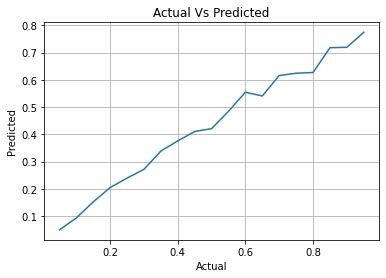

In [5]:
plt.title('Actual Vs Predicted')
plt.plot(act, pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid()
# plt.savefig('./output-predicted-vs-actual-%s.jpg'%img_path.strip().split('/')[-1].split('.png')[0].strip(), facecolor='w', edgecolor='none')
plt.show()

In [6]:
message_length_percent = 0.4

channels = [scattered_lsb_flipping(img[:, :, k], message_length_percent / 2) for k in range(img.shape[2])]

rm_p, sm_p, r_neg_p, s_neg_p = rs_helper(channels, mask)


p_flipped = [rm_p, sm_p, r_neg_p, s_neg_p]

channels = [np.bitwise_xor(channel, 1) for channel in channels]

rm_all_flip, sm_all_flip, r_neg_all_flip, s_neg_all_flip = rs_helper(channels, mask)

all_flipped = [rm_all_flip, sm_all_flip, r_neg_all_flip, s_neg_all_flip]

#Find roots
root = find_root(p_flipped, all_flipped)
p = root / (root - .5)
p = (p - initial_bias) / (1 - initial_bias)